In [1]:
import sys
sys.path.append('../vysxd')
from vysxd_analysis import *
from vysxd_define import *
from transform import *
import numpy as np
import matplotlib.pyplot as plt
from scipy import *

/home/david/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def density_transform(v: float, t: float, x: np.array):
    gamma = 1/np.sqrt(1-v**2)

    t1 = np.zeros(len(x))+t
    x1 = x

    t2 = gamma*(t1 - v*x1)
    x2 = gamma*(x1 - v*t1)
    return t2,x2

In [3]:
p1x1_files = np.sort(os.listdir('data/MS/PHA/p1x1/electrons/')) # Create a sorted list of filenames you will be analyzing
p1x1_temp = vysxd_get_data(f'data/MS/PHA/p1x1/electrons/{p1x1_files[0]}') # pick out the first timestep for reasons
time_prime, x_prime = density_transform(v=0.145,t=p1x1_temp.TIME[0],x=p1x1_temp.X)
density = -np.trapz(p1x1_temp.DATA, axis=0)

for file in p1x1_files[1:]:
    p1x1 = vysxd_get_data(f'data/MS/PHA/p1x1/electrons/{file}') # Pull the phase space data
    time_prime_temp, x_prime_temp = density_transform(v=0.135,t=p1x1.TIME[0],x=p1x1.X)
    density_temp = -np.trapz(p1x1.DATA, axis=0)

    time_prime = np.vstack((time_prime, time_prime_temp))
    x_prime = np.vstack((x_prime, x_prime_temp))
    density = np.vstack((density, density_temp))

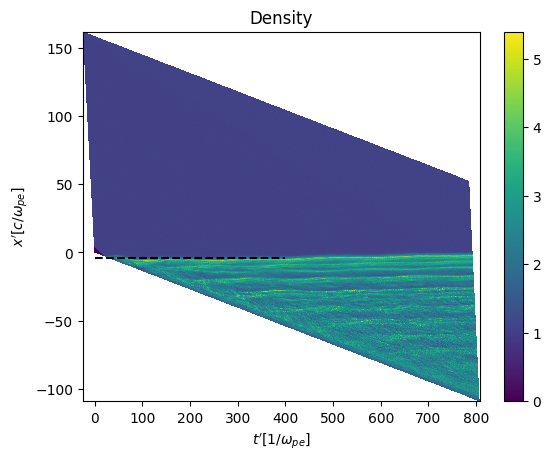

In [5]:
d_min, d_max = np.abs(density).min(), np.abs(density).max()

c = plt.pcolormesh(time_prime,x_prime, density/25, vmin = d_min/25, vmax = d_max/25)
plt.colorbar(c)
plt.ylabel(r'$x^\prime [c/\omega_{pe}]$')
plt.xlabel(r'$t^\prime [1/\omega_{pe}]$')
plt.hlines(-4,0,len(time_prime)-120, colors = 'black', linestyles= '--')
plt.title('Density')
plt.show()

In [6]:
## pull data

b1_path = 'data/MS/FLD/part_b1/'
b2_path = 'data/MS/FLD/part_b2/'
b3_path = 'data/MS/FLD/part_b3/'


b1= get_osiris_quantity_1d(b1_path)
b1_0 = vysxd_get_data(f'{b1_path}part_b1-000000.h5') ##can use this for easy labeling

b2 = get_osiris_quantity_1d(b2_path)
b2_0 = vysxd_get_data(f'{b2_path}part_b2-000000.h5')

b3 = get_osiris_quantity_1d(b3_path)
b3_0 = vysxd_get_data(f'{b3_path}part_b3-000000.h5')


e1_path = 'data/MS/FLD/part_e1/'
e2_path = 'data/MS/FLD/part_e2/'
e3_path = 'data/MS/FLD/part_e3/'

e1 = get_osiris_quantity_1d(e1_path)
e1_0 = vysxd_get_data(f'{e1_path}part_e1-000000.h5') ##can use this for easy labeling

e2 = get_osiris_quantity_1d(e2_path)
e2_0 = vysxd_get_data(f'{e2_path}part_e2-000000.h5')

e3 = get_osiris_quantity_1d(e3_path)
e3_0 = vysxd_get_data(f'{e3_path}part_e3-000000.h5')

e_density = get_osiris_quantity_1d('data/MS/DENSITY/electrons/charge/')
e_density_0 = vysxd_get_data('data/MS/DENSITY/electrons/charge/charge-electrons-000000.h5')

i_density = get_osiris_quantity_1d('data/MS/DENSITY/ions/charge/')
i_density_0 = vysxd_get_data('data/MS/DENSITY/ions/charge/charge-ions-000000.h5')

e_ufl1 = get_osiris_quantity_1d('data/MS/UDIST/electrons/ufl1/')
e_ufl1_0 = vysxd_get_data('data/MS/UDIST/electrons/ufl1/ufl1-electrons-000000.h5')

# Useful to keep these as global variables
dt, dx, t, x = e1[1], e1[2], e1[3], e1[4]

In [7]:
# write_quantities can be used to integrate shit and then leave it as .npy files that we can load very easily
# note that quantity_ indicates an averaged quantity... I don't know if there is a better practice

e_density_, e_density_err_ = np.load("avg_q/e_density.npy")
i_density_, i_density_err_ = np.load("avg_q/i_density.npy")

e1_, e1_err_ = np.load("avg_q/e1.npy")
e2_, e2_err_ = np.load("avg_q/e2.npy")
e3_, e3_err_ = np.load("avg_q/e3.npy")

b1_, b1_err_ = np.load("avg_q/b1.npy")
b2_, b2_err_ = np.load("avg_q/b2.npy")
b3_, b3_err_ = np.load("avg_q/b3.npy")

e_ufl1_, e_ufl1_err_ = np.load("avg_q/e_ufl1.npy")
# e_ufl2_, e_ufl2_err_ = np.load("avg_q/e_ufl2.npy")
# e_ufl3_, e_ufl3_err_ = np.load("avg_q/e_ufl3.npy")

i_ufl1_, i_ufl1_err_ = np.load("avg_q/i_ufl1.npy")
# i_ufl2_, i_ufl2_err_ = np.load("avg_q/i_ufl2.npy")
# i_ufl3_, i_ufl3_err_ = np.load("avg_q/i_ufl3.npy")

In [8]:
e_first_moment_, _ = np.load("avg_q/e_first_moment.npy")
i_first_moment_, _ = np.load("avg_q/i_first_moment.npy")

### Let's focus on verifying the Rankine-Huginiot jump conditions

First, we can extract the density and flow velocity from our simulation output in order to verify mass continuity

$$
[[\rho v_n]] = 0
$$

Downstream average is: 2.358 +/- 0.215
Upstream average is: 1.014


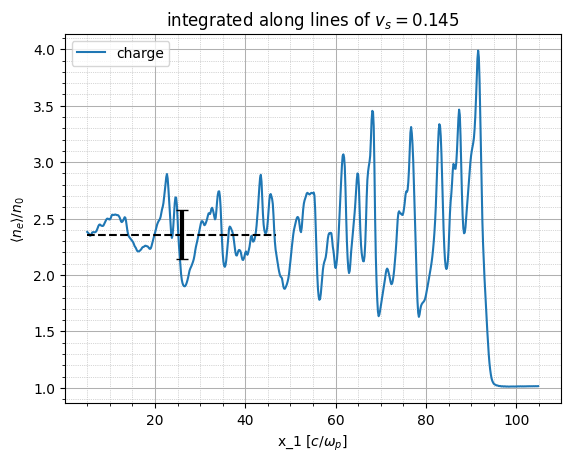

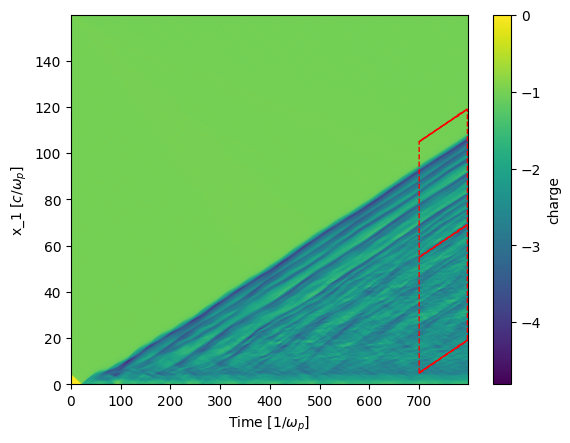

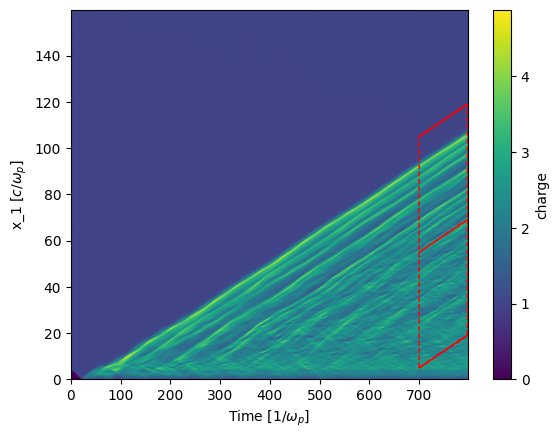

In [9]:
xmin = 5; xmax = 105; tmin = 700;tmax =797; v=.145; sf_index = 300

# plot_quantity(e_density_,xmin = xmin, xmax = xmax, v=v, x = x, dx = dx, q_0 = e_density_0,shock_front_index=sf_index)
plot_quantity(i_density_,xmin = xmin, xmax = xmax, v=v, x = x, dx = dx, q_0 = i_density_0,shock_front_index=sf_index)
plt.ylabel(r'$\langle n_e \rangle /n_0$')
plt.grid(visible=True,which='major',lw=.75)
plt.grid(visible=True,which='minor',ls= ':',lw=.5)
plt.minorticks_on()
illustrate_box(q=e_density,xmin=xmin,xmax=xmax,tmin=tmin,tmax=tmax, v= v, q_0 = e_density_0)

illustrate_box(q=i_density,xmin=xmin,xmax=xmax,tmin=tmin,tmax=tmax, v= v, q_0 = i_density_0)

In [11]:
def pretty_plot(RH,color = 'black'):
    plt.hlines(np.mean(RH[0:sf_index]),xmin=xmin,xmax=sf_index*dx, linestyles="--", color = color)
    plt.errorbar((xmin+sf_index*dx)/2,np.mean(RH[0:sf_index]), yerr=np.std(RH[0:sf_index]), xerr=None, linestyle = 'None',elinewidth=3,capsize=4, color = color)


    print(f"Downstream average is: {round(np.mean(RH[0:sf_index]),3)} +/- {round(np.std(RH[0:sf_index]),3)}")
    print(f"Upstream average is: {round(np.mean(RH[-15:-1]),3)}")

    plt.grid(visible=True,which='major',lw=.75)
    plt.grid(visible=True,which='minor',ls= ':',lw=.5)
    plt.minorticks_on()

Downstream average is: -0.148 +/- 0.012
Upstream average is: -0.342
Downstream average is: -0.148 +/- 0.013
Upstream average is: -0.342


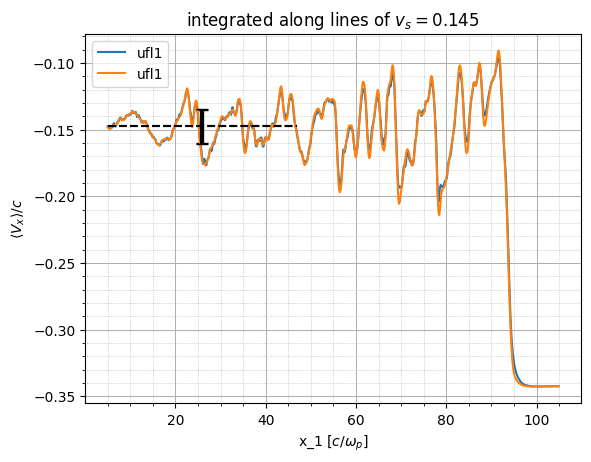

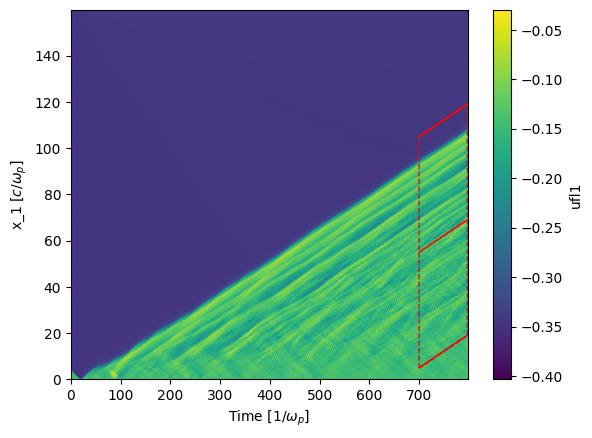

In [12]:
plot_quantity(-v+e_ufl1_,xmin = xmin, xmax = xmax, v=v, x = x, dx = dx, q_0 = e_ufl1_0,shock_front_index=sf_index)
plot_quantity(-v+i_ufl1_,xmin = xmin, xmax = xmax, v=v, x = x, dx = dx, q_0 = e_ufl1_0,shock_front_index=sf_index)
plt.ylabel(r'$\langle V_x \rangle /c$')

plt.grid(visible=True,which='major',lw=.75)
plt.grid(visible=True,which='minor',ls= ':',lw=.5)
plt.minorticks_on()

illustrate_box(q=[-v+e_ufl1[0],e_ufl1[1],e_ufl1[2],e_ufl1[3],e_ufl1[4]],xmin=xmin,xmax=xmax,tmin=tmin,tmax=tmax, v= v, q_0 = e_ufl1_0)

In [14]:
'''When working with an electron-ion plasma, it is necessary that we use a center-of-mass velocity'''

ufl1_ = (1*e_ufl1_+10*i_ufl1_)/(1+10)
# ufl2_ = (1*e_ufl2_+10*i_ufl2_)/(1+10)
# ufl3_ = (1*e_ufl3_+10*i_ufl3_)/(1+10)

Downstream average is: -0.691 +/- 0.014
Upstream average is: -0.694


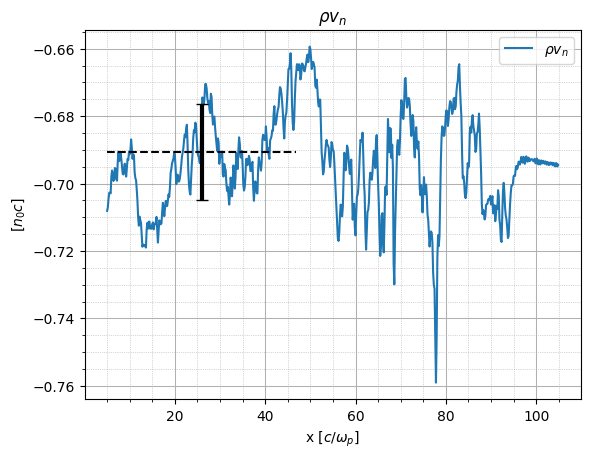

In [15]:
RH_1 = -(-v+ufl1_)*e_density_ + (-v+ufl1_)*i_density_

plt.plot(x[int(xmin/dx):int(xmax/dx)], RH_1, label = r"$\rho v_n$")
plt.ylabel(r"$[n_0 c]$")
plt.xlabel(r"x $[c/\omega_p]$")


pretty_plot(RH_1)

plt.title(r"$\rho v_n$")
plt.legend()

ValueError: x and y must have same first dimension, but have shapes (640,) and (608,)

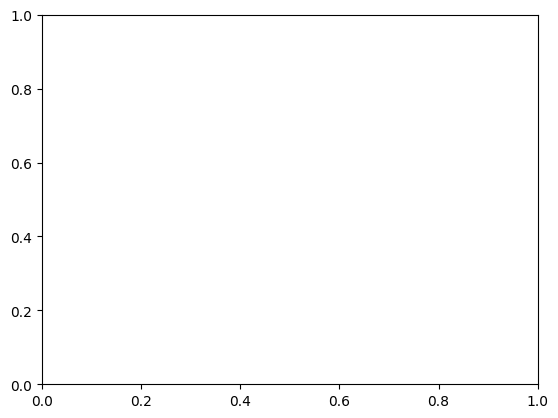

In [16]:
RH_1 = e_first_moment_ + i_first_moment_
plt.plot(x[int(xmin/dx):int(xmax/dx)], RH_1, label = r"$\rho v_n$")
plt.ylabel(r"$[n_0 c]$")
plt.xlabel(r"x $[c/\omega_p]$")


pretty_plot(RH_1)

plt.title(r"$\rho v_n$")
plt.legend()

### Next, we can easily verify the continuity of the normal B field
$$
[[B_n]]=0
$$

Downstream average is: 0.0 +/- 0.0
Upstream average is: 0.0


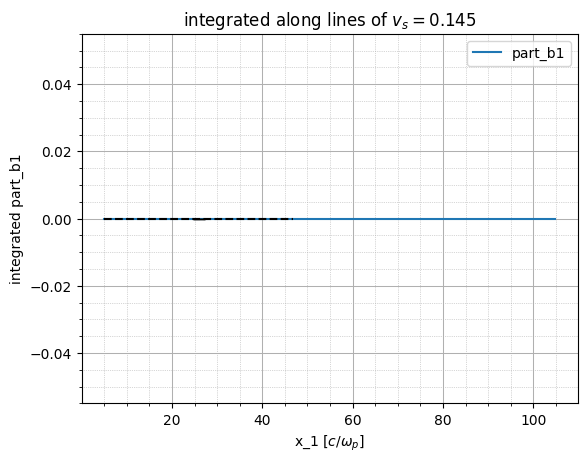

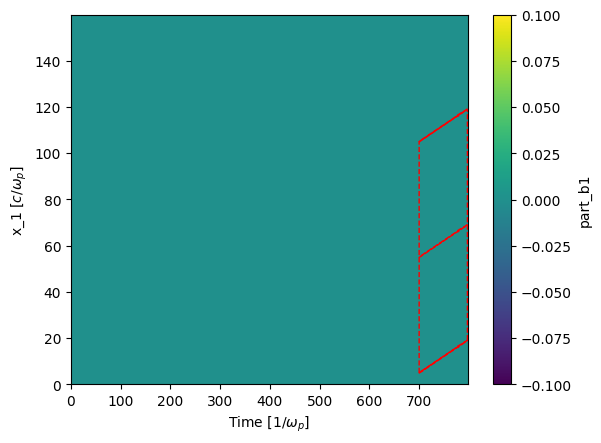

In [17]:
plot_quantity(b1_,xmin = xmin, xmax = xmax, v=v, x = x, dx = dx, q_0 = b1_0,shock_front_index=sf_index)
plt.grid(visible=True,which='major',lw=.75)
plt.grid(visible=True,which='minor',ls= ':',lw=.5)
plt.minorticks_on()
illustrate_box(q=b1,xmin=xmin,xmax=xmax,tmin=tmin,tmax=tmax,v = v, q_0=b1_0)

### Now, we verify the continuity of the tangential E field
$$
[[\mathbf{E_T}]]=[[v_n \mathbf{B_T} - B_n \mathbf{v_T}]]=0
$$

In [15]:
RH_2 = np.multiply(-v+ufl1_,b3_) - np.multiply(b1_,e_ufl3_)

plot_quantity(e2_,x=x,xmin=xmin,xmax=xmax,v=v,dx=dx,q_0=e2_0,shock_front_index=sf_index)
plt.plot(x[int(xmin/dx):int(xmax/dx)], RH_2,label= "$v_x B_z - B_x v_z$")

plt.xlabel('x $[c/\omega_p]$')
plt.ylabel(r'$E_y [e \frac{c / \omega_p}{m_e c^2}]$')

pretty_plot(RH_2,color = 'orange')

plt.legend()


NameError: name 'ufl3_' is not defined

Now, do the same for the other component

Downstream average is: -0.0 +/- 0.0
Upstream average is: 0.0
Downstream average is: -0.0 +/- 0.0
Upstream average is: -0.0


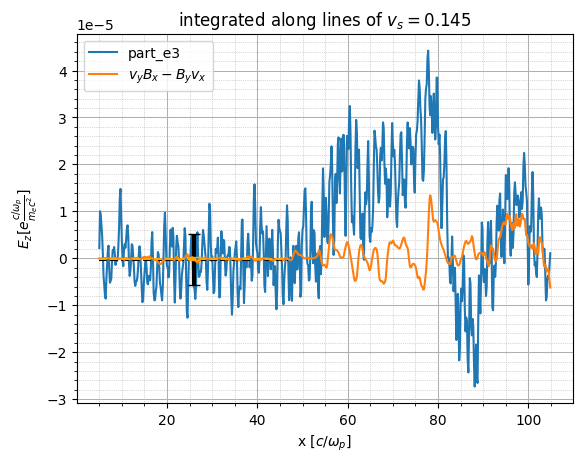

In [18]:
plot_quantity(e3_,xmin = xmin, xmax = xmax, v=v, x = x, dx = dx, q_0 = e3_0,shock_front_index=sf_index)


RH_2 = -np.multiply(ufl1_,b2_) #+ np.multiply(e_ufl2_,b1_) 

plt.plot(x[int(xmin/dx):int(xmax/dx)], RH_2,label= "$v_y B_x - B_y v_x$")

plt.xlabel('x $[c/\omega_p]$')
plt.ylabel(r'$E_z [e \frac{c / \omega_p}{m_e c^2}]$')

pretty_plot(RH_2,color = "orange")

plt.legend()

### Let's verify the third jump condition

$$[[\rho v_{n}^{2}+p+{\frac {1}{2\mu _{0}}}B_{T}^{2}]] = 0$$

Downstream average is: 0.966 +/- 0.041
Upstream average is: 0.339


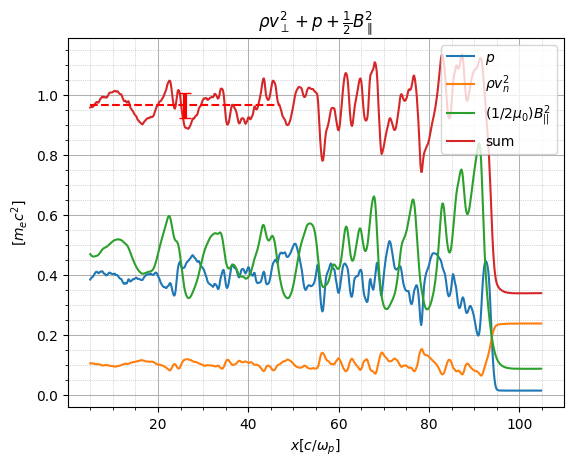

In [20]:
e_temperature_, _ = np.load('avg_q/e_temp.npy')
i_temperature_, _ = np.load('avg_q/i_temp.npy')

pressure_ = e_temperature_ + 10*i_temperature_

plt.plot(x[int(xmin/dx):int(xmax/dx)],pressure_, label = r'$p$')


RH_3 = np.multiply(-1*e_density_, np.square(-v+ufl1_)) +np.multiply(i_density_, np.square(-v+ufl1_)) + pressure_ + 1/2*(np.square(b2_)+np.square(b3_))

plt.plot(x[int(xmin/dx):int(xmax/dx)],np.multiply(-1*e_density_, np.square(-v+ufl1_)) +np.multiply(i_density_, np.square(-v+ufl1_)), label = r"$\rho v_n^2$")
plt.plot(x[int(xmin/dx):int(xmax/dx)],1/2*(np.square(b2_)+np.square(b3_)), label = r"$(1/2\mu_0) B_{||}^2$")
plt.plot(x[int(xmin/dx):int(xmax/dx)],RH_3, label = 'sum')

plt.ylabel(r"$[m_e c^2]$")
plt.xlabel(r"$x [c/\omega_p]$")
plt.title(r"$\rho v_{\perp}^{2}+p+{\frac {1}{2}}B_{\parallel }^{2}$")

pretty_plot(RH_3,color = "red")

plt.minorticks_on()
plt.legend()

### Let's verify the fouth jump condition

$$
[[\rho v_n \mathbf {v_T}- \frac {1}{\mu _{0}}\mathbf{B_T} B_n]]=0
$$

Downstream average is: -3.591 +/- 0.109
Upstream average is: -3.698


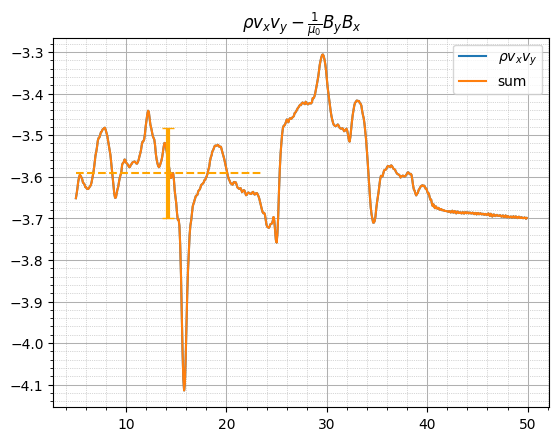

In [ ]:
RH_4 = np.multiply(-1*e_density_,-v+e_ufl1_,e_ufl2_) + np.multiply(i_density_,-v+i_ufl1_,i_ufl2_)- np.multiply(b1_,b2_) # did not include ufl2_

plt.plot(x[int(xmin/dx):int(xmax/dx)],np.multiply(-1*e_density_,-v+e_ufl1_) + np.multiply(i_density_,-v+i_ufl1_), label = r"$\rho v_x v_y$")
# plt.plot(x[int(xmin/dx):int(xmax/dx)],np.multiply(b1_,b2_), label = r"$\frac{1}{4 \pi} (B_{||}^2)$")
plt.plot(x[int(xmin/dx):int(xmax/dx)],RH_4, label = 'sum')

plt.title(r"$\rho v_x v_y- \frac {1}{\mu _{0}} B_y B_x$")

pretty_plot(RH_4,color = 'orange')

plt.legend()

In [ ]:
RH_4 = np.multiply(-1*e_density_,-v+e_ufl1_,e_ufl3_) + np.multiply(i_density_,-v+i_ufl1_,i_ufl3_) - np.multiply(b1_,b3_)
plt.plot(x[int(xmin/dx):int(xmax/dx)],np.multiply(-1*e_density_,-v+e_ufl1_,e_ufl3_) + np.multiply(i_density_,-v+i_ufl1_,i_ufl3_), label = r"$\rho v_x v_y$")
# plt.plot(x[int(xmin/dx):int(xmax/dx)],np.multiply(b1_,b2_), label = r"$\frac{1}{4 \pi} (B_{||}^2)$")
plt.plot(x[int(xmin/dx):int(xmax/dx)],RH_4, label = 'sum')


plt.title(r"$\rho v_x v_z- \frac {1}{\mu _{0}} B_z B_x$")
plt.xlabel(r"x $[c/\omega_p]$")

pretty_plot(RH_4,color = 'orange')
plt.legend()

NameError: name 'e_ufl3_' is not defined

$$\left[\left[\left({\frac {\gamma }{\gamma -1}}{\frac {p}{\rho}}+{\frac {v^{2}}{2}}\right)\rho v_{n}+{\frac {1}{\mu _{0}}}\left[{v_{n}B_{T}^{2}}-{B_{n}(\mathbf {B} _{T}\cdot \mathbf {v} _{T})}\right]\right]\right]=0$$

In [ ]:
gamma = 2

## Split this up into the form: term1*term2 + term3 - term4

term1 = gamma/(gamma-1)*np.multiply(pressure_,1/(-1*e_density_+i_density_))+\
    (np.square(-v+e_ufl1_)+np.square(e_ufl2_)+np.square(e_ufl3_))/2+\
    (np.square(-v+i_ufl1_)+np.square(i_ufl2_)+np.square(i_ufl3_))/2

term2 = np.multiply(-1*e_density_+i_density_,-v+i_ufl1_)

term3 = np.multiply(-v+i_ufl1_, np.square(b2_) + np.square(b3_))

term4 = np.multiply(b1_,(np.multiply(b2_,i_ufl2_)+np.multiply(b3_,i_ufl3_)))

RH_5 = np.multiply(term1,term2) + term3 - term4

Downstream average is: -39.07 +/- 3.718
Upstream average is: -42.698


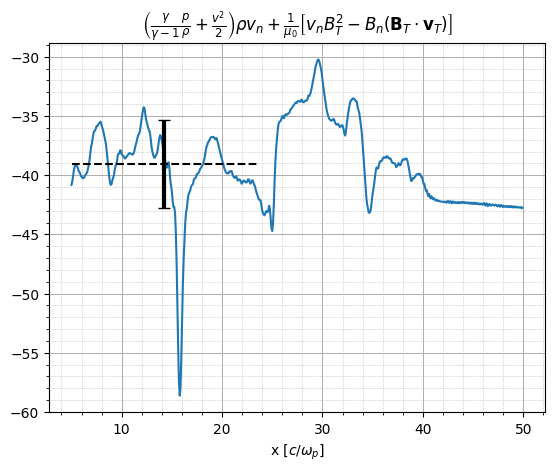

In [ ]:
plt.plot(x[int(xmin/dx):int(xmax/dx)],RH_5)

plt.title(r"$\left({\frac {\gamma }{\gamma -1}}{\frac {p}{\rho}}+{\frac {v^{2}}{2}}\right)\rho v_{n}+{\frac {1}{\mu _{0}}}\left[{v_{n}B_{T}^{2}}-{B_{n}(\mathbf {B} _{T}\cdot \mathbf {v} _{T})}\right]$")

plt.xlabel(r"x $[c/\omega_p]$")

pretty_plot(RH_5)